In [1]:
import numpy as np
import pandas as pd
import sqlite3

from rubin_sim.maf.metrics import BaseMetric
from rubin_sim.maf.slicers import UserPointsSlicer
import rubin_sim.maf.metrics as metrics
import rubin_sim.maf as maf

In [2]:
# databases at https://s3df.slac.stanford.edu/groups/rubin/static/sim-data/sims_featureScheduler_runs3.4/too/
db_file = 'too_100_4v3.4_10yrs.db'
run_name = db_file.replace('.db', '')
out_dir = 'temp'
results_db = maf.db.ResultsDb(out_dir=out_dir)

In [3]:
# find the list of ToO events 
con = sqlite3.connect(db_file)
too_events = pd.read_sql('select * from events', con)
con.close()


In [4]:
# Generate a slicer to look at each event
# This just looks at the center. In theory, we might want to look at the extended area
# around the ToO event. In practice, I think this should all average out. E.g.,
# sometimes the ToO event will land on a field overlap, sometimes it will land on a chip gap
# sometimes it gets all the requested observations, sometimes it doesn't, etc. 
# Sampling at the center should be about as good as taking many samples and averaging. 
def gen_too_slicer(mjd_starts, ra_rad, dec_rad, file_indx=0, distance=50):
    slicer = UserPointsSlicer(np.degrees(ra_rad), np.degrees(dec_rad), lat_lon_deg=True, badval=0)
    slicer.slice_points["peak_time"] = mjd_starts
    # XXX--which file to use?
    slicer.slice_points["file_indx"] = file_indx
    # Distance to use? Probably in Mpc
    slicer.slice_points["distance"] = distance
    return slicer

In [5]:
bundle_list = []

slicer = gen_too_slicer(too_events["mjd_start"].values, too_events["ra"].values, too_events["dec"].values)
metric = maf.PrestoColorKNePopMetric(mjd0=0, skyregion="extragalactic",)

summary = [
    # XXX--maybe this should be a probability sum?
        metrics.SumMetric(metric_name="Total detected"),
        metrics.CountMetric(metric_name="Total lightcurves in footprint"),
        metrics.CountMetric(metric_name="Total lightcurves on sky", mask_val=0),
        metrics.MeanMetric(mask_val=0, metric_name="Fraction detected of total (mean)"),
    ]

bundle = maf.MetricBundle(
        metric,
        slicer,
        "",
        run_name=run_name,
        summary_metrics=summary,
    )
bundle_list.append(bundle)

/Users/yoachim/git_repos/rubin_sim/rubin_sim/maf/plots/plot_handler.py:575: UserWarning: Cannot plot object metric values with this plotter.
  warnings.warn("Cannot plot object metric values with this plotter.")


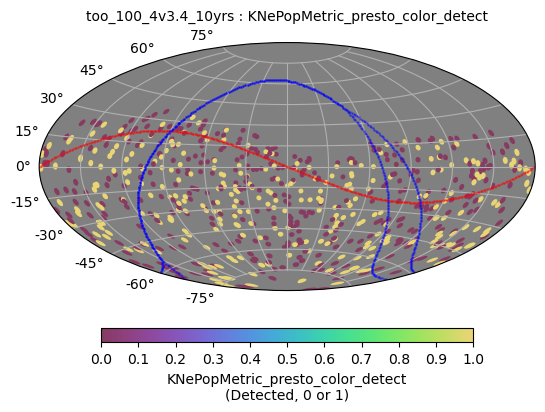

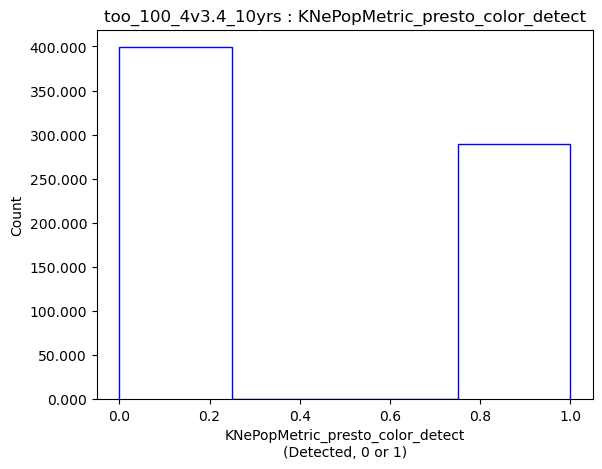

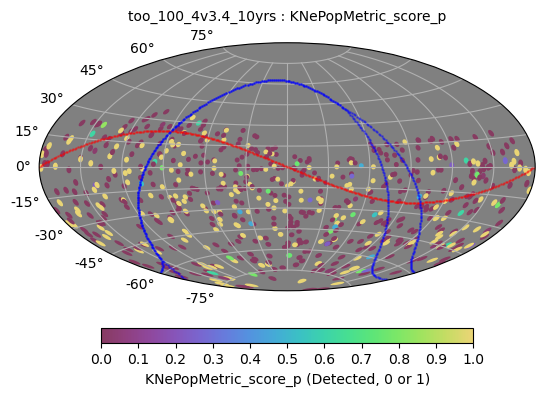

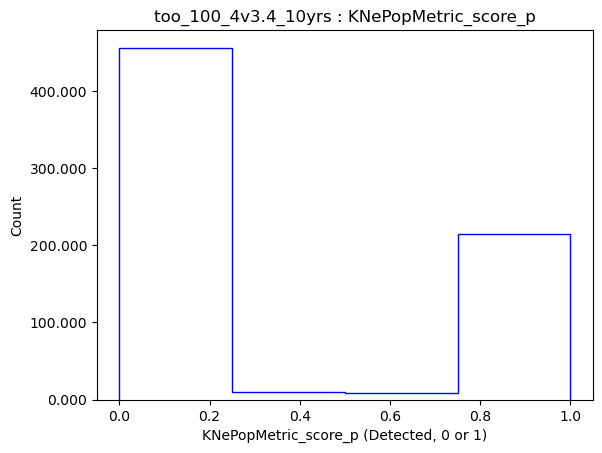

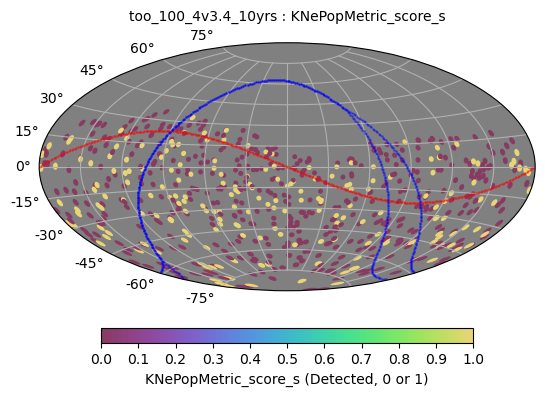

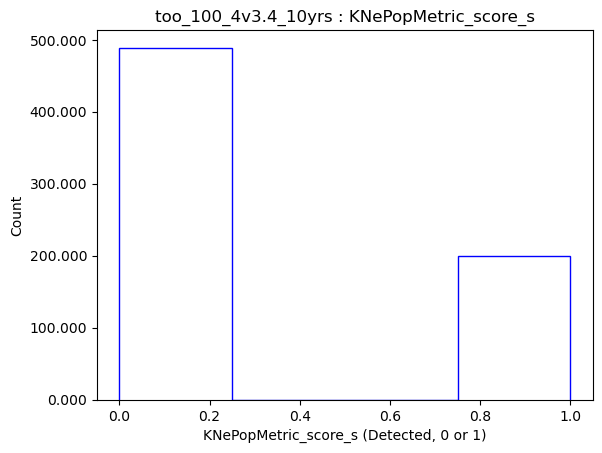

In [6]:
bd = maf.metricBundles.make_bundles_dict_from_list(bundle_list)
bg = maf.metricBundles.MetricBundleGroup(bd, db_file, out_dir=out_dir, results_db=results_db)
bg.run_all()
bg.plot_all(closefigs=False)

In [7]:
bd

{'too_100_4v3_4_10yrs_KNePopMetric_USER': <rubin_sim.maf.metric_bundles.metric_bundle.MetricBundle at 0x107e6c850>,
 'KNePopMetric_presto_color_detect': <rubin_sim.maf.metric_bundles.metric_bundle.MetricBundle at 0x157339950>,
 'KNePopMetric_score_p': <rubin_sim.maf.metric_bundles.metric_bundle.MetricBundle at 0x1572e2810>,
 'KNePopMetric_score_s': <rubin_sim.maf.metric_bundles.metric_bundle.MetricBundle at 0x1577a6250>}

In [8]:
bd['KNePopMetric_score_p'].summary_values

{'Total detected': 221.72003019223445,
 'Total lightcurves in footprint': 689,
 'Total lightcurves on sky': 1000,
 'Fraction detected of total (mean)': 0.22172003019223444}

In [9]:
bd['KNePopMetric_score_s'].summary_values

{'Total detected': 200.0,
 'Total lightcurves in footprint': 689,
 'Total lightcurves on sky': 1000,
 'Fraction detected of total (mean)': 0.2}